In [58]:
import numpy as np
import re
import pickle
import random
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib.pyplot import figure
from PIL import Image
import requests
from io import BytesIO
import os
import seaborn as sns
from scipy import sparse
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error

In [3]:
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

This data list has all the product related information like length of the dress, neckline, sleeve type etc.,

In [4]:
all_product_data_list = pd.read_csv('products.csv')
all_product_data_list.head()

,product_id,designer_name,displayName,length,neckline,productDetails,retailPrice,season,sleeve,stylistNotes,price_base,price_adjusted,ageRanges_teens,ageRanges_early_twenties,ageRanges_late_twenties,ageRanges_thirties,ageRanges_forties_plus,bodyTypes_apple,bodyTypes_athletic,bodyTypes_full_bust,bodyTypes_hourglass,bodyTypes_pear,bodyTypes_petite,bodyTypes_straight_narrow,bodyTypes_bump_friendly,colors_green,colors_white,colors_print,colors_multicolored,colors_blue,colors_cream,colors_black,colors_pink,colors_red,colors_brown,colors_yellow,colors_orange,colors_purple,colors_gold,colors_grey,colors_silver,colors_crystal_clear,colors_pearl,occasions_wedding,occasions_party,occasions_vacation,occasions_weekend,occasions_date,occasions_work,occasions_formal_affair,embellishments_florals,embellishments_cut_outs,embellishments_color_block,embellishments_abstract_prints,embellishments_maxis,embellishments_pastels,embellishments_lace,embellishments_pockets,embellishments_metallics,embellishments_peplum,embellishments_sequins,embellishments_beaded,product_img_link
0,CRCR18,Cara Cara New York,Juju Dress,tea_length,square,<p>White floral (100% Cotton Poplin). Casual d...,USD 525.00,spring_summer,sleeveless,<p>This Cara Cara New York dress features a ch...,50.0,50.0,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,https://pc-ap.rtrcdn.com/productimages/front/1...
1,ADAMC171,Adam Lippes Collective,Floral Pleated Midi Dress,tea_length,square,"<p>Chiffon (97% Cotton, 3% Spandex). Casual Dr...",USD 445.00,spring_summer,sleeveless,<p>The Floral Pleated Midi Dress by Adam Lippe...,40.0,40.0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,https://pc-ap.rtrcdn.com/productimages/front/1...
2,MDW381,Madewell,Bianca Dress,tea_length,sweetheart,<p>Blue striped (100% Cotton). Casual dress. S...,USD 138.00,spring_summer,sleeveless,<p>This breezy blue and white striped midi dre...,30.0,30.0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,https://pc-ap.rtrcdn.com/productimages/front/1...
3,SRUE1,Rue Sophie,Eli Dress,tea_length,square,"<p>Off-white (67% Rayon, 26% Nylon, 7% Spandex...",USD 188.00,spring_summer,sleeveless,<p>This Sophie Rue white midi dress offers a t...,30.0,30.0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,https://pc-ap.rtrcdn.com/productimages/front/1...
4,ALC289,A.L.C.,Alexandria Midi Dress,tea_length,v_neck,<p>White (100% Cotton). Casual dress. Cap slee...,USD 495.00,spring_summer,cap_sleeve,<p>This A.L.C. white dress features a twist-fr...,45.0,45.0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,https://pc-ap.rtrcdn.com/productimages/front/1...


# Preprocessing

In [5]:
review_data = pd.read_csv('reviews.csv')
review_data.head()

,product_id,averageRating,countRatings,currentCount,user_id,bodyType,bustSize,numReviewsByUser,height,heightInches,standardSize,usStandardSize,weight,weightPounds,caption,content,fit,rating,reviewId,uploadedAt,product_img_link
0,CRCR18,7.0,3,3,21194830,Hourglass,36C,95,NaN,70.0,NaN,10.0,NaN,162.0,Feminine fit,This was a pretty dress. I brought it on vacat...,True to Size,8,2939989,"Apr 08, 2024 9:10:51 PM",https://pc-ap.rtrcdn.com/productimages/front/1...
1,CRCR18,7.0,3,3,19471194,Hourglass,NaN,24,NaN,64.0,NaN,2.0,NaN,110.0,Team RTR Review,"A beautiful, easy vacation dress! Unfortunatel...",Large,8,2927834,"Mar 25, 2024 7:28:00 PM",https://pc-ap.rtrcdn.com/productimages/front/1...
2,CRCR18,7.0,3,3,11604948,Hourglass,32DD,3,NaN,68.0,NaN,4.0,NaN,135.0,Cute but didn’t wear,NaN,True to Size,6,2933106,"Apr 01, 2024 6:39:47 PM",https://pc-ap.rtrcdn.com/productimages/front/1...
3,ADAMC171,9.0,3,3,22091421,Straight & narrow,34C,77,NaN,65.0,NaN,2.0,NaN,125.0,RTR Team Review,Loved this flowy and feminine dress from Adam ...,True to Size,10,2933881,"Apr 02, 2024 4:15:40 PM",https://pc-ap.rtrcdn.com/productimages/front/1...
4,ADAMC171,9.0,3,3,22164997,Petite,32A,17,NaN,70.0,NaN,2.0,NaN,120.0,Lovely,"Gorgeous dress, fits and feels great, extremel...",True to Size,10,2940474,"Apr 09, 2024 2:18:33 PM",https://pc-ap.rtrcdn.com/productimages/front/1...


In [6]:
review_data.shape

(249271, 21)

### Drop some fields

In [7]:
review_data.drop(columns = ['currentCount', 'height', 'standardSize', 'weight'], inplace = True)

In [8]:
review_data.describe()

,averageRating,countRatings,user_id,numReviewsByUser,heightInches,usStandardSize,weightPounds,rating,reviewId
count,249271.000000,249271.000000,2.492710e+05,249271.000000,246855.000000,248027.000000,2.169420e+05,249271.000000,2.492710e+05
mean,8.308227,65.095258,1.601754e+07,40.897445,65.350072,6.420470,1.544335e+05,8.677897,2.602475e+06
std,0.884483,116.723146,6.811039e+06,97.165352,2.669056,3.997845,1.172168e+07,2.163762,2.842033e+05
min,0.000000,0.000000,1.000174e+06,1.000000,54.000000,0.000000,0.000000e+00,0.000000,8.724000e+03
25%,8.000000,29.000000,1.067240e+07,4.000000,63.000000,4.000000,1.270000e+02,8.000000,2.449318e+06
50%,8.000000,46.000000,1.828603e+07,11.000000,65.000000,6.000000,1.400000e+02,10.000000,2.678887e+06
75%,9.000000,75.000000,2.188341e+07,33.000000,67.000000,8.000000,1.550000e+02,10.000000,2.820207e+06
max,10.000000,4632.000000,2.361793e+07,1302.000000,124.000000,22.000000,1.701651e+09,10.000000,2.945185e+06


## Fix variable types

### Numeric Data

In [9]:
review_data = review_data.astype({'numReviewsByUser': 'int',
                                  'rating': 'int', 
                                  'heightInches': 'float',
                                  'weightPounds': 'float'})

### US Standard Size

In [10]:
review_data['usStandardSize'].unique(), review_data['usStandardSize'].dtype

(array([10.,  2.,  4.,  6., 18., 12.,  8.,  0., 14., 16., nan, 20., 22.]),
 dtype('float64'))

In [11]:
review_data.head()

,product_id,averageRating,countRatings,user_id,bodyType,bustSize,numReviewsByUser,heightInches,usStandardSize,weightPounds,caption,content,fit,rating,reviewId,uploadedAt,product_img_link
0,CRCR18,7.0,3,21194830,Hourglass,36C,95,70.0,10.0,162.0,Feminine fit,This was a pretty dress. I brought it on vacat...,True to Size,8,2939989,"Apr 08, 2024 9:10:51 PM",https://pc-ap.rtrcdn.com/productimages/front/1...
1,CRCR18,7.0,3,19471194,Hourglass,NaN,24,64.0,2.0,110.0,Team RTR Review,"A beautiful, easy vacation dress! Unfortunatel...",Large,8,2927834,"Mar 25, 2024 7:28:00 PM",https://pc-ap.rtrcdn.com/productimages/front/1...
2,CRCR18,7.0,3,11604948,Hourglass,32DD,3,68.0,4.0,135.0,Cute but didn’t wear,NaN,True to Size,6,2933106,"Apr 01, 2024 6:39:47 PM",https://pc-ap.rtrcdn.com/productimages/front/1...
3,ADAMC171,9.0,3,22091421,Straight & narrow,34C,77,65.0,2.0,125.0,RTR Team Review,Loved this flowy and feminine dress from Adam ...,True to Size,10,2933881,"Apr 02, 2024 4:15:40 PM",https://pc-ap.rtrcdn.com/productimages/front/1...
4,ADAMC171,9.0,3,22164997,Petite,32A,17,70.0,2.0,120.0,Lovely,"Gorgeous dress, fits and feels great, extremel...",True to Size,10,2940474,"Apr 09, 2024 2:18:33 PM",https://pc-ap.rtrcdn.com/productimages/front/1...


### Date Time

In [12]:
review_data['uploadedAt'].dtype

dtype('O')

In [13]:
review_data['uploadedAt'] = pd.to_datetime(review_data['uploadedAt'])

In [14]:
review_data.head()

,product_id,averageRating,countRatings,user_id,bodyType,bustSize,numReviewsByUser,heightInches,usStandardSize,weightPounds,caption,content,fit,rating,reviewId,uploadedAt,product_img_link
0,CRCR18,7.0,3,21194830,Hourglass,36C,95,70.0,10.0,162.0,Feminine fit,This was a pretty dress. I brought it on vacat...,True to Size,8,2939989,2024-04-08 21:10:51,https://pc-ap.rtrcdn.com/productimages/front/1...
1,CRCR18,7.0,3,19471194,Hourglass,NaN,24,64.0,2.0,110.0,Team RTR Review,"A beautiful, easy vacation dress! Unfortunatel...",Large,8,2927834,2024-03-25 19:28:00,https://pc-ap.rtrcdn.com/productimages/front/1...
2,CRCR18,7.0,3,11604948,Hourglass,32DD,3,68.0,4.0,135.0,Cute but didn’t wear,NaN,True to Size,6,2933106,2024-04-01 18:39:47,https://pc-ap.rtrcdn.com/productimages/front/1...
3,ADAMC171,9.0,3,22091421,Straight & narrow,34C,77,65.0,2.0,125.0,RTR Team Review,Loved this flowy and feminine dress from Adam ...,True to Size,10,2933881,2024-04-02 16:15:40,https://pc-ap.rtrcdn.com/productimages/front/1...
4,ADAMC171,9.0,3,22164997,Petite,32A,17,70.0,2.0,120.0,Lovely,"Gorgeous dress, fits and feels great, extremel...",True to Size,10,2940474,2024-04-09 14:18:33,https://pc-ap.rtrcdn.com/productimages/front/1...


### Bust data - We will split this to hold the bist size and cup size separately

In [15]:
review_data['bustSize'].unique()

array(['36C', nan, '32DD', '34C', '32A', '34B', '36A', '38DDD/E', '34D',
       '36B', '32B', '32C', '34A', '36D', '36DD', '32D', '28AA', '40C',
       '38H', '28DD', '34DD', '40DDD/E', '34DDD/E', '40G', '32DDD/E',
       '42D', '38C', '38D', '36DDD/E', '38B', '40B', '28C', '32G', '34I',
       '40D', '38DD', '34D+', '30D', '34F', '30B', '28A', '42C', '30DD',
       '38G', '36G', '30A', '40DD', '28DDD/E', '30G', '36AA', '36I',
       '38A', '36H', '36J', '34G', '30DDD/E', '36F', '32H', '28B', '38F',
       '28D', '30C', '32F', '32AA', '40H', '34H', '30AA', '42G', '30F',
       '44G', '34AA', '42DDD/E', '28G', '44DDD/E', '44DD', '40A', '42DD',
       '30H', '34J', '40F', '42H', '32J', '38J', '38I', '42B', '38AA',
       '36D+', '42F', '46D', '32I', '44C', '32D+', '30J', '40AA', '44H',
       '28H', '46C', '46DDD/E', '46DD', '44F', '28F', '44D', '48DD',
       '42I', '48J', '28J', '38D+', '44AA', '50B', '42J', '46H', '44B',
       '40I', '40J', '44J', '42A', '48DDD/E', '28I', '48G'], dty

In [16]:
bust_data = review_data['bustSize'].str.extract('([^a-zA-Z]+)([a-zA-Z]+)', expand=True)
bust_data.columns = ['bust_size', 'bust_type']
review_data = review_data.join(bust_data)
review_data = review_data.astype({'bust_size': 'float'})
review_data = review_data.drop(columns=['bustSize'])

In [17]:
review_data.head()

,product_id,averageRating,countRatings,user_id,bodyType,numReviewsByUser,heightInches,usStandardSize,weightPounds,caption,content,fit,rating,reviewId,uploadedAt,product_img_link,bust_size,bust_type
0,CRCR18,7.0,3,21194830,Hourglass,95,70.0,10.0,162.0,Feminine fit,This was a pretty dress. I brought it on vacat...,True to Size,8,2939989,2024-04-08 21:10:51,https://pc-ap.rtrcdn.com/productimages/front/1...,36.0,C
1,CRCR18,7.0,3,19471194,Hourglass,24,64.0,2.0,110.0,Team RTR Review,"A beautiful, easy vacation dress! Unfortunatel...",Large,8,2927834,2024-03-25 19:28:00,https://pc-ap.rtrcdn.com/productimages/front/1...,NaN,NaN
2,CRCR18,7.0,3,11604948,Hourglass,3,68.0,4.0,135.0,Cute but didn’t wear,NaN,True to Size,6,2933106,2024-04-01 18:39:47,https://pc-ap.rtrcdn.com/productimages/front/1...,32.0,DD
3,ADAMC171,9.0,3,22091421,Straight & narrow,77,65.0,2.0,125.0,RTR Team Review,Loved this flowy and feminine dress from Adam ...,True to Size,10,2933881,2024-04-02 16:15:40,https://pc-ap.rtrcdn.com/productimages/front/1...,34.0,C
4,ADAMC171,9.0,3,22164997,Petite,17,70.0,2.0,120.0,Lovely,"Gorgeous dress, fits and feels great, extremel...",True to Size,10,2940474,2024-04-09 14:18:33,https://pc-ap.rtrcdn.com/productimages/front/1...,32.0,A


## Missing Values

In [18]:
review_data.isnull().sum()

product_id              0
averageRating           0
countRatings            0
user_id                 0
bodyType             6258
numReviewsByUser        0
heightInches         2416
usStandardSize       1244
weightPounds        32329
caption               263
content             25064
fit                 12755
rating                  0
reviewId                0
uploadedAt              0
product_img_link        0
bust_size           32818
bust_type           32818
dtype: int64

### Numeric

In [19]:
print(review_data['heightInches'].mean(), review_data['heightInches'].median())
review_data['heightInches'].fillna(review_data['heightInches'].median(), inplace = True)

65.35007190455936 65.0


<Axes: >

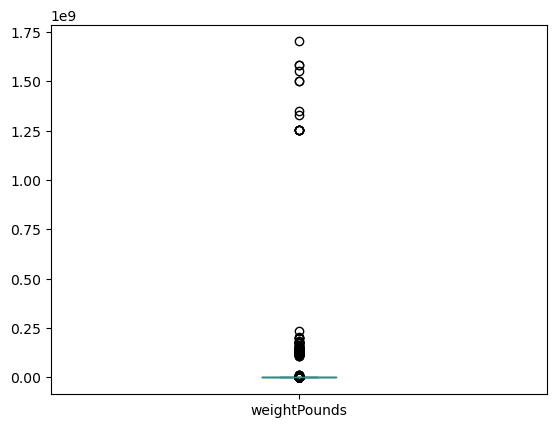

In [20]:
review_data['weightPounds'].plot.box()

In [21]:
print(review_data['weightPounds'].mean(), review_data['weightPounds'].median())
review_data['weightPounds'].fillna(review_data['weightPounds'].median(), inplace = True)

154433.54480460216 140.0


### Categorical

In [22]:
print(review_data['bodyType'].value_counts())
review_data['bodyType'].fillna(review_data['bodyType'].value_counts().index[0], inplace = True)

Hourglass            73393
Athletic             61110
Pear                 29667
Petite               28074
Straight & narrow    20850
Full Bust            20670
Apple                 9249
Name: bodyType, dtype: int64


In [23]:
print(review_data['bust_size'].value_counts())
review_data['bust_size'].fillna(review_data['bust_size'].value_counts().index[0], inplace = True)

34.0    91128
36.0    53163
32.0    47818
38.0    14948
30.0     4264
40.0     2351
28.0     1883
42.0      652
44.0      200
46.0       37
48.0        8
50.0        1
Name: bust_size, dtype: int64


In [24]:
print(review_data['bust_type'].value_counts())

types = ['C', 'B']
idx = review_data.loc[review_data['bust_type'].isna() == True].index

for i in idx:
    pos = random.randint(0,1)
    review_data['bust_type'].iloc[i] = types[pos]


C      58359
B      55095
D      39555
DD     28341
A      17080
DDD    10796
G       2639
F       2082
AA      1257
H        829
I        210
J        210
Name: bust_type, dtype: int64


/var/folders/rx/0lw0w5ds7t36p51ggtr6fdr80000gn/T/ipykernel_95008/2200703993.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_data['bust_type'].iloc[i] = types[pos]


In [25]:
review_data['bust_type'].value_counts()

C      74758
B      71514
D      39555
DD     28341
A      17080
DDD    10796
G       2639
F       2082
AA      1257
H        829
I        210
J        210
Name: bust_type, dtype: int64

In [26]:
print(review_data['usStandardSize'].value_counts())
review_data['usStandardSize'].fillna(review_data['usStandardSize'].value_counts().index[0], inplace = True)

4.0     53525
6.0     47643
8.0     36215
2.0     31177
10.0    26204
12.0    18848
0.0     17666
14.0    10310
16.0     4651
18.0     1308
20.0      329
22.0      151
Name: usStandardSize, dtype: int64


In [27]:
print(review_data['fit'].value_counts())
review_data['fit'].fillna(review_data['fit'].value_counts().index[0], inplace = True)

True to Size    180792
Large            30289
Small            25435
Name: fit, dtype: int64


### Remaining values

In [28]:
review_data.isnull().sum()

product_id              0
averageRating           0
countRatings            0
user_id                 0
bodyType                0
numReviewsByUser        0
heightInches            0
usStandardSize          0
weightPounds            0
caption               263
content             25064
fit                     0
rating                  0
reviewId                0
uploadedAt              0
product_img_link        0
bust_size               0
bust_type               0
dtype: int64

# EDA

In [29]:
# Unique users
print("No. of users:", review_data['user_id'].nunique())

No. of users: 102988


In [30]:
# Unique products
print("No. of products:", review_data['product_id'].nunique())

No. of products: 9105


In [31]:
# Time period
print("From", review_data['uploadedAt'].min(), "to", review_data['uploadedAt'].max())

From 2011-02-23 22:06:37 to 2024-04-15 03:28:56


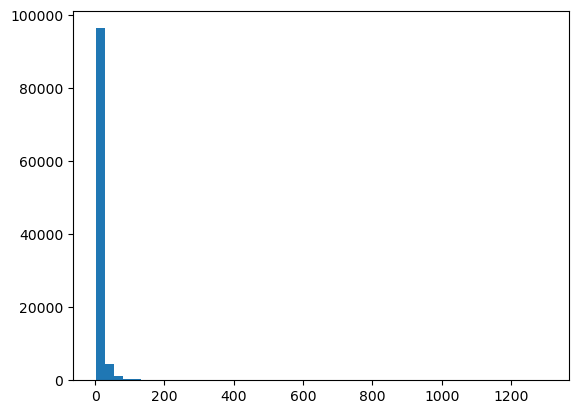

In [32]:
#Number of Reviews by user
temp = review_data.drop_duplicates('user_id')
plt.hist(temp.loc[:,'numReviewsByUser'], bins = 50)
plt.show()

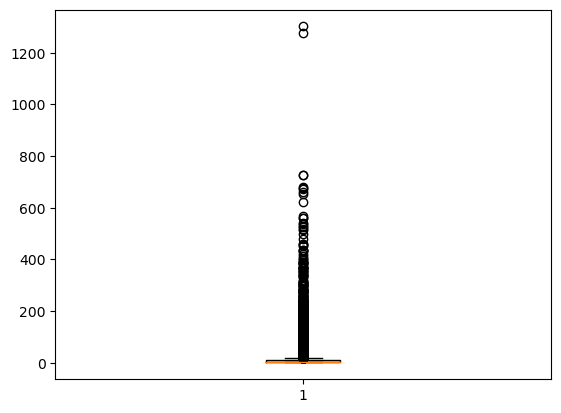

In [33]:
plt.boxplot(temp['numReviewsByUser'])
plt.show()

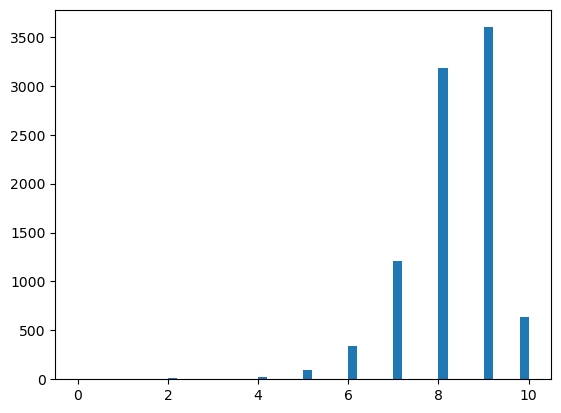

In [34]:
#average Rating
temp = review_data.drop_duplicates('product_id')
plt.hist(temp.loc[:,'averageRating'], bins = 50)
plt.show()

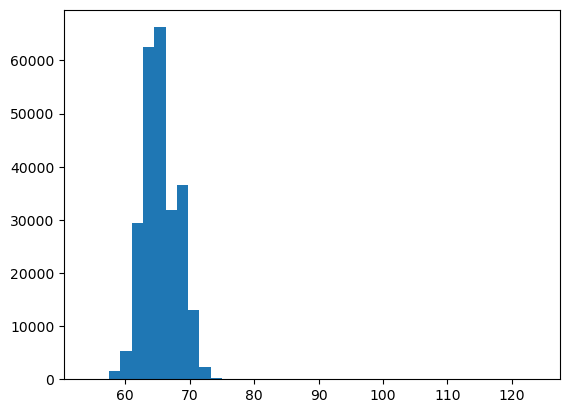

In [35]:
#height
plt.hist(review_data['heightInches'], bins = 40)
plt.show()

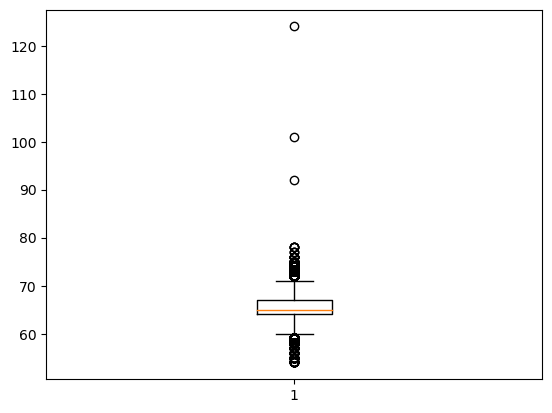

In [36]:
plt.boxplot(review_data['heightInches'])
plt.show()

In [37]:
h_idx = review_data.loc[review_data['heightInches'] > 75].index 
for idx in h_idx:
    review_data['heightInches'].iloc[idx] = review_data['heightInches'].median()

/var/folders/rx/0lw0w5ds7t36p51ggtr6fdr80000gn/T/ipykernel_95008/910608316.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_data['heightInches'].iloc[idx] = review_data['heightInches'].median()


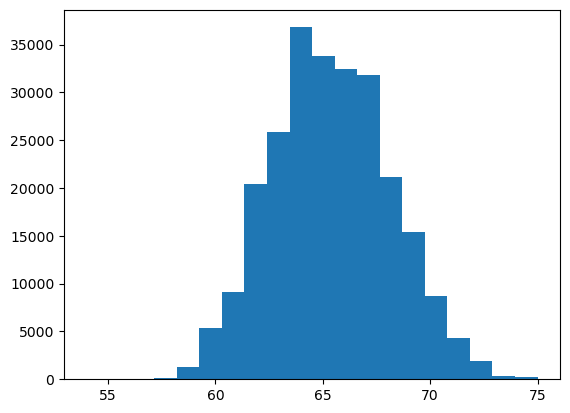

In [38]:
#height
plt.hist(review_data['heightInches'], bins = 20)
plt.show()

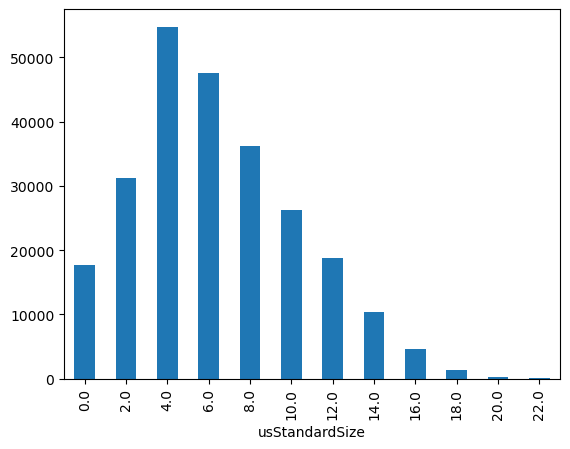

In [39]:
#US Standard sizes
us_size_grouped = review_data.groupby(['usStandardSize']).size()
us_size_grouped.plot(kind='bar')
plt.show()

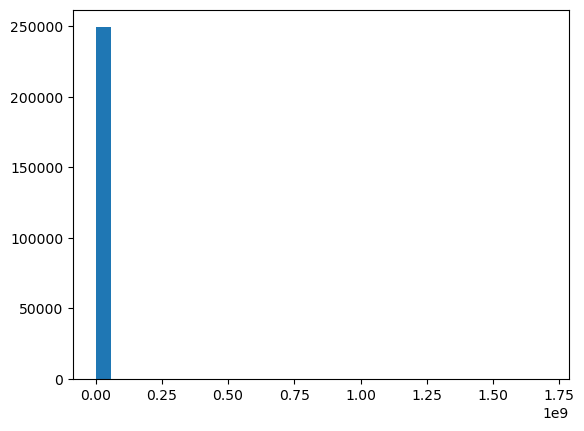

In [40]:
# Weight
plt.hist(review_data['weightPounds'], bins = 30)
plt.show()

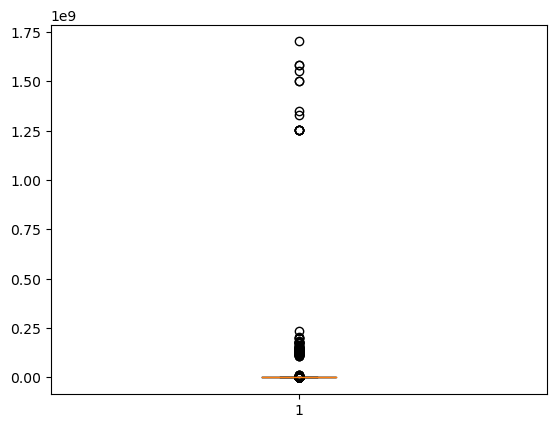

In [41]:
plt.boxplot(review_data['weightPounds'])
plt.show()

In [42]:
w_idx = review_data.loc[review_data['weightPounds'] > 300].index
for idx in w_idx:
    review_data['weightPounds'].iloc[idx] = review_data['weightPounds'].median()

/var/folders/rx/0lw0w5ds7t36p51ggtr6fdr80000gn/T/ipykernel_95008/3773554557.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_data['weightPounds'].iloc[idx] = review_data['weightPounds'].median()


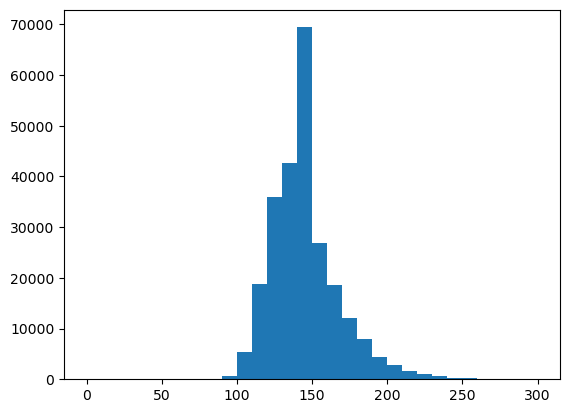

In [43]:
# Weight
plt.hist(review_data['weightPounds'], bins = 30)
plt.show()

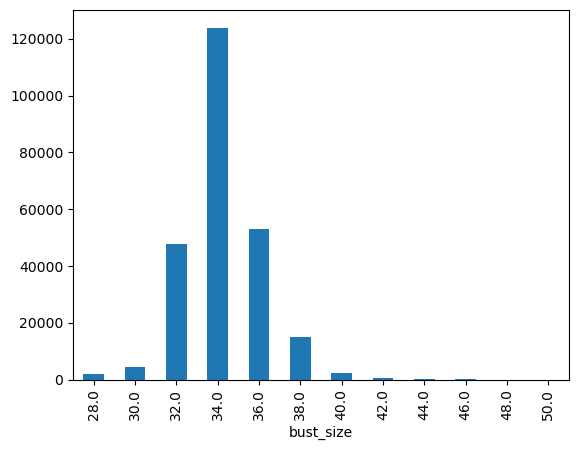

In [44]:
# Bust size
bust_size_grouped = review_data.groupby(['bust_size']).size()
bust_size_grouped.plot(kind = 'bar')
plt.show()

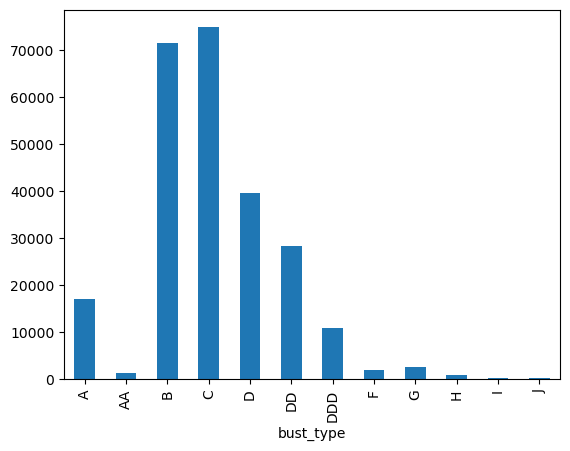

In [45]:
# Bust type
bust_type_grouped = review_data.groupby(['bust_type']).size()
bust_type_grouped.plot(kind = 'bar')
plt.show()

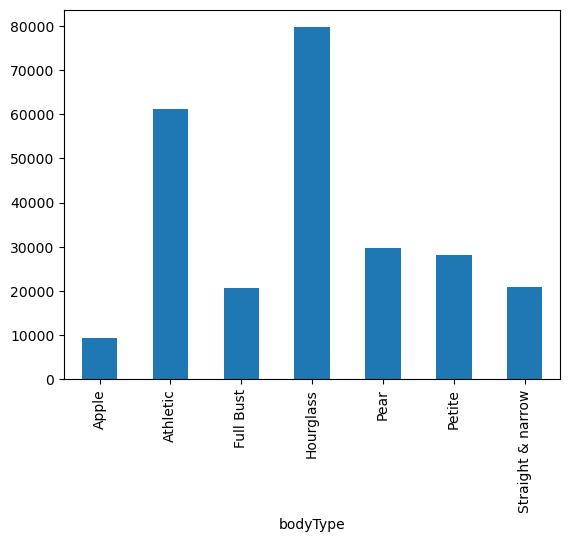

In [46]:
#Body type
body_type_grouped = review_data.groupby(['bodyType']).size()
body_type_grouped.plot(kind ='bar')
plt.show()

## Dummy Features

In [47]:
dummy_features = ['bodyType', 'fit', 'bust_type']

for ft in dummy_features:
    ft_dummies = pd.get_dummies(review_data[ft], prefix=ft)
    review_data = review_data.join(ft_dummies)
    review_data.drop(columns = [ft], inplace = True)

In [48]:
review_data.head()

,product_id,averageRating,countRatings,user_id,numReviewsByUser,heightInches,usStandardSize,weightPounds,caption,content,rating,reviewId,uploadedAt,product_img_link,bust_size,bodyType_Apple,bodyType_Athletic,bodyType_Full Bust,bodyType_Hourglass,bodyType_Pear,bodyType_Petite,bodyType_Straight & narrow,fit_Large,fit_Small,fit_True to Size,bust_type_A,bust_type_AA,bust_type_B,bust_type_C,bust_type_D,bust_type_DD,bust_type_DDD,bust_type_F,bust_type_G,bust_type_H,bust_type_I,bust_type_J
0,CRCR18,7.0,3,21194830,95,70.0,10.0,162.0,Feminine fit,This was a pretty dress. I brought it on vacat...,8,2939989,2024-04-08 21:10:51,https://pc-ap.rtrcdn.com/productimages/front/1...,36.0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
1,CRCR18,7.0,3,19471194,24,64.0,2.0,110.0,Team RTR Review,"A beautiful, easy vacation dress! Unfortunatel...",8,2927834,2024-03-25 19:28:00,https://pc-ap.rtrcdn.com/productimages/front/1...,34.0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,CRCR18,7.0,3,11604948,3,68.0,4.0,135.0,Cute but didn’t wear,NaN,6,2933106,2024-04-01 18:39:47,https://pc-ap.rtrcdn.com/productimages/front/1...,32.0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
3,ADAMC171,9.0,3,22091421,77,65.0,2.0,125.0,RTR Team Review,Loved this flowy and feminine dress from Adam ...,10,2933881,2024-04-02 16:15:40,https://pc-ap.rtrcdn.com/productimages/front/1...,34.0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
4,ADAMC171,9.0,3,22164997,17,70.0,2.0,120.0,Lovely,"Gorgeous dress, fits and feels great, extremel...",10,2940474,2024-04-09 14:18:33,https://pc-ap.rtrcdn.com/productimages/front/1...,32.0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0


## Lets visualise similar users first

In [169]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [170]:
pca = PCA(n_components=2)
pca.fit(data_std.iloc[:,1:])

PCA(n_components=2)

In [172]:
pca_data = pca.transform(data_std.iloc[:,1:])

In [173]:
pca_full_data = pd.concat([users, pd.DataFrame(pca_data)], axis = 1)
pca_full_data

,user_id,0,1
0,21194830,-0.893152,-0.404472
1,19471194,0.010369,1.049574
2,22091421,-0.229538,-0.408376
3,22164997,0.167301,-0.261108
4,19482641,0.017267,-0.210132
...,...,...,...
22755,15762809,-0.109616,1.050540
22756,15925540,0.622951,0.936262
22757,11720168,0.699671,-0.191365
22758,9519846,-0.866102,-0.407888


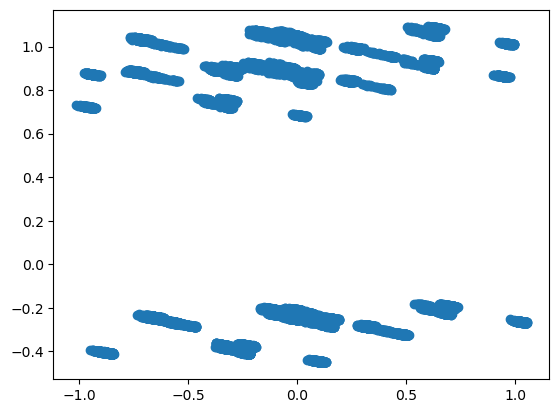

In [174]:
plt.scatter(pca_full_data[0], pca_full_data[1])
plt.show()

## TSNE

In [175]:
tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(data_std.iloc[:,1:])

In [176]:
tsne_full_data = pd.concat([users, pd.DataFrame(tsne_data)], axis = 1)
tsne_full_data.head()

,user_id,0,1
0,21194830,-57.949093,-42.777451
1,19471194,-40.293541,104.486702
2,22091421,-12.987391,-84.453949
3,22164997,31.205492,-2.641449
4,19482641,-4.436833,12.819399


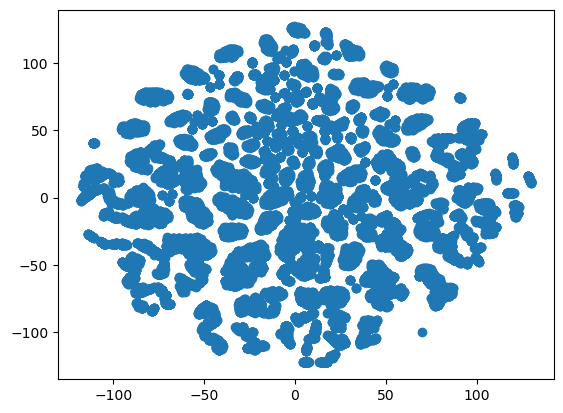

In [177]:
plt.scatter(tsne_full_data[0], tsne_full_data[1])
plt.show()

## UMAP

In [182]:
import umap
from umap import UMAP

In [183]:
umap_embedder = umap.UMAP(n_neighbors=30, n_components=2)
umap_data = umap_embedder.fit_transform(data_std.iloc[:,1:])

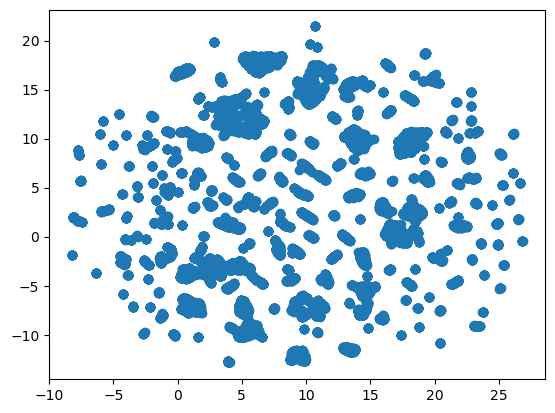

In [184]:
umap_full_data = pd.concat([users, pd.DataFrame(umap_data)], axis = 1)

plt.scatter(umap_full_data[0], umap_full_data[1])
plt.show()

## Sparse Matrix of User Vectors

### User-Item attributes

#### Get unique users and products

In [50]:
all_users = review_data['user_id'].value_counts()
filter_ = all_users >= 3 # Filter users with at least these number of ratings
users = list(all_users[filter_].index)

all_products = review_data.loc[review_data['user_id'].isin(users), 'product_id'].value_counts()
products = list(all_products.index)

In [51]:
user_attributes = ['user_id', 'heightInches','usStandardSize','weightPounds','bust_size','bodyType_Apple','bodyType_Athletic',
                'bodyType_Full Bust','bodyType_Hourglass','bodyType_Pear','bodyType_Petite','bodyType_Straight & narrow','fit_Large','fit_Small',
                'fit_True to Size','bust_type_A','bust_type_AA','bust_type_B','bust_type_C','bust_type_D','bust_type_DD','bust_type_DDD',
                'bust_type_F','bust_type_G','bust_type_H','bust_type_I','bust_type_J']

In [54]:
review_data_nodup = review_data.drop_duplicates('user_id')
review_data_nodup = review_data_nodup[user_attributes]
review_data_nodup = review_data_nodup.loc[review_data_nodup['user_id'].isin(users), :]

In [55]:
review_data_nodup.reset_index(drop = True, inplace = True)
review_data_nodup.head()

,user_id,heightInches,usStandardSize,weightPounds,bust_size,bodyType_Apple,bodyType_Athletic,bodyType_Full Bust,bodyType_Hourglass,bodyType_Pear,bodyType_Petite,bodyType_Straight & narrow,fit_Large,fit_Small,fit_True to Size,bust_type_A,bust_type_AA,bust_type_B,bust_type_C,bust_type_D,bust_type_DD,bust_type_DDD,bust_type_F,bust_type_G,bust_type_H,bust_type_I,bust_type_J
0,21194830,70.0,10.0,162.0,36.0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
1,19471194,64.0,2.0,110.0,34.0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,22091421,65.0,2.0,125.0,34.0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
3,22164997,70.0,2.0,120.0,32.0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
4,19482641,62.0,6.0,138.0,32.0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0


In [56]:
users = review_data_nodup['user_id']
user_data = review_data_nodup.iloc[:,1:]

In [59]:
scaler = MinMaxScaler()
user_data_std = scaler.fit_transform(user_data)

In [60]:
data_std = pd.concat([users, pd.DataFrame(user_data_std)], axis = 1)
data_std.head()

,user_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,21194830,0.761905,0.454545,0.540000,0.444444,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,19471194,0.476190,0.090909,0.366667,0.333333,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,22091421,0.523810,0.090909,0.416667,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,22164997,0.761905,0.090909,0.400000,0.222222,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,19482641,0.380952,0.272727,0.460000,0.222222,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
data_std.columns = review_data_nodup.columns
data_std.head()

,user_id,heightInches,usStandardSize,weightPounds,bust_size,bodyType_Apple,bodyType_Athletic,bodyType_Full Bust,bodyType_Hourglass,bodyType_Pear,bodyType_Petite,bodyType_Straight & narrow,fit_Large,fit_Small,fit_True to Size,bust_type_A,bust_type_AA,bust_type_B,bust_type_C,bust_type_D,bust_type_DD,bust_type_DDD,bust_type_F,bust_type_G,bust_type_H,bust_type_I,bust_type_J
0,21194830,0.761905,0.454545,0.540000,0.444444,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,19471194,0.476190,0.090909,0.366667,0.333333,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,22091421,0.523810,0.090909,0.416667,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,22164997,0.761905,0.090909,0.400000,0.222222,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,19482641,0.380952,0.272727,0.460000,0.222222,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Calculating Cosine Similarity between users based on users' attributes

In [62]:
temp_data = data_std.set_index('user_id')

In [63]:
sim_mat = cosine_similarity(temp_data)

In [64]:
sim_df = pd.DataFrame(sim_mat, index=temp_data.index, columns=temp_data.index)
sim_df

user_id   21194830  19471194  22091421  22164997  19482641  20593937  \
user_id                                                                
21194830  1.000000  0.453682  0.720364  0.480529  0.456565  0.508638   
19471194  0.453682  1.000000  0.148022  0.162771  0.128986  0.180057   
22091421  0.720364  0.148022  1.000000  0.447738  0.422879  0.459145   
22164997  0.480529  0.162771  0.447738  1.000000  0.425877  0.729306   
19482641  0.456565  0.128986  0.422879  0.425877  1.000000  0.444858   
...            ...       ...       ...       ...       ...       ...   
15762809  0.275491  0.438765  0.186565  0.191471  0.187216  0.243091   
15925540  0.224193  0.431652  0.160964  0.168172  0.431785  0.202890   
11720168  0.497325  0.443720  0.452443  0.455788  0.717401  0.483952   
9519846   0.987910  0.440575  0.723576  0.462891  0.434770  0.476229   
20103157  0.740705  0.157842  0.708705  0.698446  0.442159  0.474864   

user_id   22978693  22043895  18425947  11784574  10697956  18615036  \
user_id                                                                
21194830  0.296712  0.750050  0.494777  0.524361  0.756237  0.479413   
19471194  0.179015  0.717252  0.441834  0.452558  0.176013  0.427810   
22091421  0.190425  0.456186  0.449726  0.464176  0.710508  0.434002   
22164997  0.191364  0.474597  0.456800  0.483560  0.455057  0.162546   
19482641  0.206740  0.443075  0.438046  0.455844  0.717011  0.434513   
...            ...       ...       ...       ...       ...       ...   
15762809  0.535308  0.232210  0.229779  0.259858  0.270274  0.482492   
15925540  0.476138  0.458845  0.459361  0.470354  0.471691  0.453655   
11720168  0.255135  0.735209  0.735994  0.741727  0.739296  0.464975   
9519846   0.219488  0.736243  0.464742  0.485750  0.725976  0.447316   
20103157  0.272764  0.467447  0.467758  0.484133  0.744908  0.467366   

user_id   10761052  23261462  17145130  13970418  20097018  20390852  \
user_id                                                                
21194830  0.467667  0.684512  0.222752  0.188504  0.720011  0.693241   
19471194  0.420353  0.112959  0.437697  0.709482  0.710241  0.125524   
22091421  0.425890  0.703348  0.446152  0.143214  0.432600  0.708869   
22164997  0.683672  0.416864  0.460110  0.161399  0.168137  0.421916   
19482641  0.430496  0.398941  0.146404  0.416615  0.141293  0.405193   
...            ...       ...       ...       ...       ...       ...   
15762809  0.221053  0.135053  0.450909  0.430645  0.447338  0.154294   
15925540  0.448434  0.119579  0.169033  0.706593  0.155473  0.135865   
11720168  0.724939  0.417242  0.192276  0.712840  0.177629  0.430290   
9519846   0.437327  0.701485  0.187926  0.158809  0.720129  0.706996   
20103157  0.729684  0.683039  0.175785  0.150868  0.440004  0.692410   

user_id   23593137  23255319  19057226  11505156  20196859  12623110  \
user_id                                                                
21194830  0.473159  0.772170  0.474362  0.462983  0.481358  0.456674   
19471194  0.439535  0.456285  0.433361  0.429197  0.155489  0.141069   
22091421  0.721404  0.468033  0.441011  0.717776  0.441282  0.434165   
22164997  0.203962  0.488388  0.449166  0.452406  0.439521  0.713892   
19482641  0.144281  0.461958  0.429489  0.422923  0.714409  0.419168   
...            ...       ...       ...       ...       ...       ...   
15762809  0.440184  0.293873  0.200388  0.178723  0.479023  0.179792   
15925540  0.167987  0.237603  0.444379  0.431847  0.183085  0.154608   
11720168  0.192508  0.504564  0.727320  0.717736  0.468506  0.447091   
9519846   0.460330  0.736425  0.453322  0.449127  0.453652  0.443114   
20103157  0.432814  0.502508  0.449147  0.432587  0.464956  0.434420   

user_id   19753977  14973384  18852996  23391783  21207095  10195952  \
user_id                                                                
21194830  0.470554  0.707099  0.712665  0.481667  0.738322  0.504178   
19471194  0.429170  0.414104  0.1315

In [138]:
def get_top_n_similar_users(user_id, n = 5):
    similarities = sim_df[user_id]
    similarities = pd.DataFrame(similarities)
    similarities.reset_index()
    #similarities = similarities.drop(user_id)
    similarities = similarities.sort_values(by = user_id, ascending = False)
    return similarities.index[:5].to_list()

In [123]:
print(get_top_n_similar_users(20593937, 5))

[20028518, 10031420, 8809556, 16673066, 16775151]


In [65]:
file = open('predicted_ratings.pkl', 'rb')
predicted_ratings = pickle.load(file)
file.close()

In [128]:
file = open('sparse_matrix_rating.pkl', 'rb')
sparse_matrix_rating = pickle.load(file)
file.close()

In [125]:
file = open('product_mapping.pkl', 'rb')
product_mapping = pickle.load(file)
file.close()

In [126]:
file = open('user_mapping.pkl', 'rb')
user_mapping = pickle.load(file)
file.close()

In [127]:
product_mapping_reversed = {value: key for key, value in product_mapping.items()}

In [131]:
predicted_ratings_df = pd.DataFrame(predicted_ratings)

In [106]:
predicted_ratings

array([[ 9.35359596e+00, -1.90356321e-01,  6.41539311e+00, ...,
         8.88604586e+00,  3.01092471e+00,  9.75620788e-01],
       [ 1.66697368e+00,  5.01229943e-01,  1.80322378e+00, ...,
         1.31468821e+00, -5.65667041e-01,  3.20114021e-01],
       [ 5.15499170e-02, -3.99325183e-03,  3.49912182e-02, ...,
         3.40343752e-02,  5.43090860e-03,  3.20670021e-03],
       ...,
       [ 1.06890007e-03,  2.67306111e-03,  1.25440100e-02, ...,
         2.07905346e-02,  2.97156347e-02,  1.44830978e-02],
       [ 4.27560027e-03,  1.06922445e-02,  5.01760402e-02, ...,
         8.31621382e-02,  1.18862539e-01,  5.79323913e-02],
       [ 5.34450034e-03,  1.33653056e-02,  6.27200502e-02, ...,
         1.03952673e-01,  1.48578173e-01,  7.24154891e-02]])

In [163]:
def recommend(similar_users, n):
    products_list = []
    for u in similar_users:
        prods = get_top_5_products(u, 1)
        products_list.append(prods)
    
    flat_list = [item[0] for item in products_list]
    recommended_prods_df = all_product_data_list[all_product_data_list['product_id'].isin(flat_list)][['product_id', 'displayName', 'product_img_link']]
    return recommended_prods_df

In [164]:
def get_top_5_products(user_id, n=1):
    #locate the user from sparse matrix and get products that are unrated or 0
    user_mapping_val = user_mapping[user_id]
    user_unrated_prods = sparse_matrix_rating.columns[sparse_matrix_rating.iloc[user_mapping_val] == 0].tolist()
    
    unrated_approximations = predicted_ratings_df.iloc[user_mapping_val]
    unrated_approximations = unrated_approximations.iloc[user_unrated_prods].sort_values(ascending = False)
    unrated_approximations = unrated_approximations.to_frame(name = 'predicted_ratings')
    product_list = unrated_approximations.index[:n].to_list()
    
    recoms_product_ids = [product_mapping_reversed[key] for key in product_list if key in product_mapping_reversed]
    return recoms_product_ids

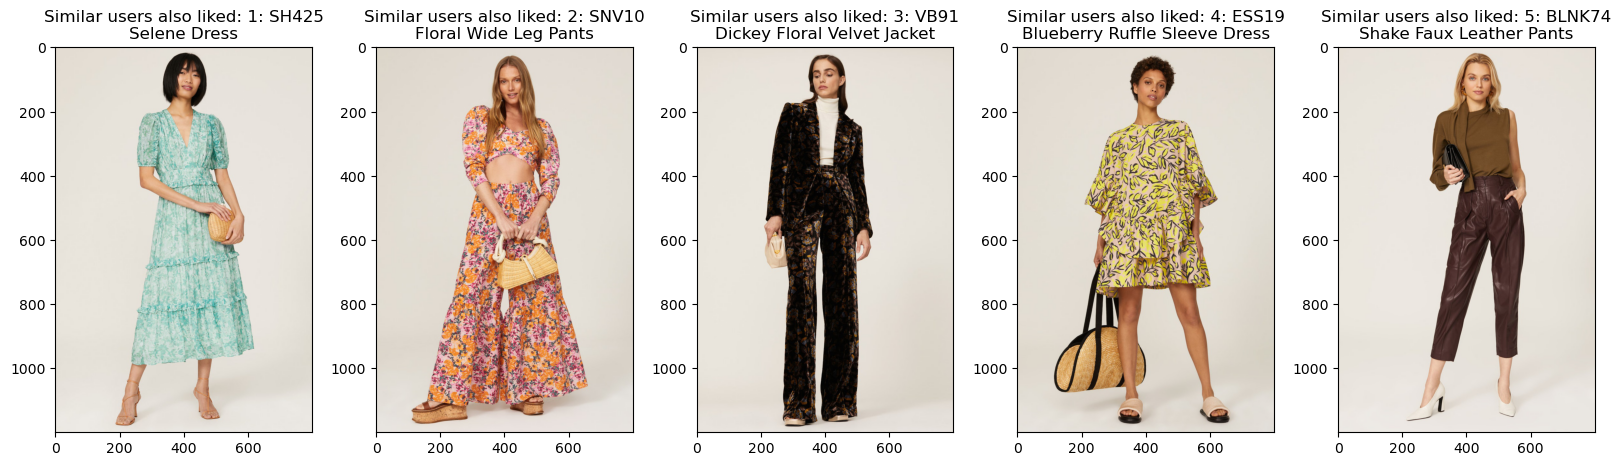

In [165]:
similar_users = get_top_n_similar_users(22164997,5)
recommendations = recommend(similar_users,5)

print_images(recommendations, 'Similar users also liked: ')
#recommended_prods_df.head()

In [142]:
def print_images(df, text_to_write):
  product_img_link = df['product_img_link'].values
  displayName = df['displayName'].values
  product = df['product_id'].values

  n = len(product_img_link)
  if n > 1:
    fig, axs = plt.subplots(1, n, figsize=(n*4, 5))
    i = 0
    for link, display_name, id_ in zip(product_img_link, displayName, product):
      if type(link) == str:
          response = requests.get(link)
          img = Image.open(BytesIO(response.content))
          axs[i].imshow(np.asarray(img))
          axs[i].set_title(str(text_to_write) + str(i+1) + ': ' + str(id_) + '\n' + str(display_name))
          # axs[i].axis('off')

      else:
        link = 'https://www.wildhareboca.com/wp-content/uploads/sites/310/2018/03/image-not-available-200x300.jpg'
        response = requests.get(link)
        img = Image.open(BytesIO(response.content))
        axs[i].imshow(np.asarray(img))
        axs[i].set_title(id_)
        # axs[i].axis('off')
      i+=1
    plt.show()

  else:
    fig, axs = plt.subplots(1, n, figsize=(n*4, 5))
    i = 0
    for link, display_name, id_ in zip(product_img_link, displayName, product):
      if type(link) == str:
          response = requests.get(link)
          img = Image.open(BytesIO(response.content))
          axs.imshow(np.asarray(img))
          axs.set_title(str(text_to_write) + str(i+1) + ': ' + str(id_) + '\n' + str(display_name))
          # axs[i].axis('off')

      else:
        link = 'https://www.wildhareboca.com/wp-content/uploads/sites/310/2018/03/image-not-available-200x300.jpg'
        response = requests.get(link)
        img = Image.open(BytesIO(response.content))
        axs.imshow(np.asarray(img))
        axs.set_title(id_)
        # axs[i].axis('off')
      i+=1
    plt.show()